首先说明一下Actor-critic是一系列算法，或者说Actor-critic是一种思想。演员评论家的思想，通过评论家来指导演员的行为,使学习更加有效率.

所以会有一系列的变种，Advantage Actor-critic(A2C),Asynchronous Actor-Critic Agents(A3C)

最开始的AC我并没有找到论文,只找到了[这本书](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf),所以我这次就实现A2C了.

最开始的Actor-critic使用的Actor网络是REINFORCE,之后再转换到Policy Gradient，再到$\delta_v$,三者最主要的区别为

REINFORCE使用$V$,Policy Gradient使用$\hat{A}(s,a)=Q(s,a)-V(s)$,而$\delta_v=r+\gamma V_v(s')-V_v(s)$来替换如下的$\square$处:

$$\theta_{t+1} = \theta_t +\alpha\square\nabla_\theta \log\pi_\theta(s|a)$$

在理解$\hat{A}(s,a)=Q(s,a)-V(s)$的过程中，产生了一些疑惑。因为实际 $V$ 值是通过神经网络返回单值获取的，代表当前状态的价值。而目标 $V$ 值

的计算是reward序列的加权累加所得的。所以TD error就这么产生了

联系到 DuelingDQN，$Q(s,a)=A(s,a)-V(s)$，其V值使用的是实际的V值，因为Q-learning系列算法使用的都是TD(1)的更新方式，不存在目标 $V$ 值的出现

贴上V和Q的计算公式吧，以免日后忘记([参考于此](https://datascience.stackexchange.com/questions/9832/what-is-the-q-function-and-what-is-the-v-function-in-reinforcement-learning))
$$V^\pi(s)=\mathbb{E}_\pi[G_t|s_t=s]$$
$$Q^\pi(s,a)=\mathbb{E}_\pi[G_t|s_t=s,a_t=a]$$
V和Q的关系($\pi$为概率):
$$V^\pi(s)=\sum_{a \in A}\pi(a|s) * Q^\pi(a,s)$$
V为所以Q采取状态的加权总和，通过上面的公式很难知道两者的区别，顶多就是一个和action有关，一个和action无关所以我们将Q定义的更加具体:
$$Q(s,a)=r(s,a)+\gamma V^∗(\delta(s,a))$$
其中 $V^*$ 为在某个状态所采取的最佳action
$$V^*(s) = {\max_{a'}}Q(s,a')$$
于是可以将$Q(s,a)$表示为:
$$Q(s,a)=r(s,a)+\gamma {\max_{a′}}Q(\delta(s,a),a′)$$

算法伪代码:<br>
Input a differentiable policy parameterization $\pi(a|s,\theta_\pi)$<br>
Input a differentiable state-value parameterization $\hat{v}(s, \theta_{\hat{v}})$<br>
Select step-size parameters $0<\alpha_\pi,\alpha_{\hat{v}}\leq 1$<br>
Initialize the parameters $\theta_{pi}, \theta_{\hat{v}}$<br>
Loop through $n$ episodes (or forever):<br>
&nbsp;&nbsp;&nbsp; Begin the episode $s_0$<br>
&nbsp;&nbsp;&nbsp; Continue to loop until the episode ends:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Get action $A_t$ from $\pi$:$\pi(S_t,\theta_\pi) \to A_t$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Take action $A_t$ and observe reward ($R_t$) and the new state($S_{t+1}$)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculate the TD target:$G_t \leftarrow R_t + \gamma \hat{v}(S_{t+1},\theta_{\hat{v}})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculate the TD error:$\delta_t\leftarrow R_t +\gamma\hat{v}(S_{t+1},\theta_{\hat{v}})-\hat{v}(S_t,\theta_{\hat{v}})$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculate the critic loss $L(\theta_{\hat{v}})=\frac{1}{T}\sum^T_{t=1}(\hat{v}(S_t,\theta_\hat{v})-G_t)^2$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculate the actor loss $L(\theta\pi)=-\sum^T_{t=1}ln(\pi(A_t|S_t,\theta_\pi))\delta_t$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update actor parameters through backpropagation:$\theta_\pi:=\theta_\pi+\alpha_\pi\nabla_\pi L(\theta_\pi)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update critic parameters through backpropagation:$\theta_{\hat{v}}:=\theta_{\hat{v}}+\alpha_{\hat{v}}\nabla_{\hat{v}}L(\theta_{\hat{v}})$

![actor_critic_image](../assets/actor_critic_image.png)<br>
在真正实现的时候，TD target使用的是每次奖励乘上折扣值的和也就是$G_t$

而TD error中的 $\hat{v}(S_t,\theta_{\hat{v}})$指的是当前状态的V值

在计算Loss的时候我们会将$L(\theta\pi)$,$L(\theta_{\hat{v}})$相加并再加上一个熵(entropy)函数$H(\pi)=-\sum^n_{i=1} P(x_i)log_b(P(x_i)))$<br>
公式中$P(x_i)$为动作i的概率，$log_b$中的b为动作的状态空间

所以总的Loss funciton为:
$$L = 0.5 * \frac{1}{T}\sum^T_{t=1}(\hat{v}(S_t,\theta_\hat{v})-G_t)^2  -\sum^T_{t=1}ln(\pi(A_t|S_t,\theta_\pi))\delta_t - \beta * H(\pi)$$

在动作sample的时候使用的虽然是actor，但计算Loss的时候加上了critic loss, critic loss 乘上了0.5是为了降低critic的作用。这样一来，就可以理解critic为什么对actor有指导作用了。actor sample了不好的action,会造成较高的critic loss,由此对actor进行惩罚。反之，critic loss较低，对actor进行奖励(此处的奖励和惩罚是相对的)。
但是，critic不一定就是正确的。在critic成熟之前，必须要做出更多的探索，不然会容易会陷入局部。由此有了熵函数的出现。

由熵函数定义和下图可知: 以二元分布为例，当两者被sample的概率相等时(熵函数的目标是达到这种状态)，熵函数是最大的。当两者被sample的概率一个为0一个为1时熵函数是最小的。加到损失函数中时会乘上-1，则相反。由此，当分布过于极端(一个为0，一个为1)时会得到较高的loss，将参数重重地更新一次。

A2C的四种实现方式 :其主要区别在于TD_error中TD_target的实现方式和所使用的数据来源<br>
1. One-step Actor-Critic:<br>
    TD_target = $R+\gamma\hat{v}(S',w)$,其中 $\hat{v}$ 使用的为下个state的value值
    * 使用环境的单次更新来实现(不实用)
    * 使用和环境的一次完整的互动(开始训练直到done)。将其转化为多维数组，作为一个batch进行更新,[链接](https://github.com/seungeunrho/minimalRL/blob/master/actor_critic.py)
2. 路径更新
    TD_target = $R+\gamma\hat{v}(S',w)$,其中 $\hat{v}$ 使用的为整条路径的$V(t)$，也就是说使用reward来进行无偏估计
    * 使用单个环境，使用一次完整的互动(开始训练直到done)。[链接](https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py)
    * 使用多个环境，但每个环境是同步的，环境们互动几次后再更新。[链接](https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb)

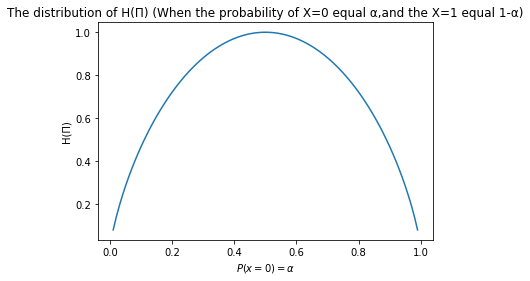

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(0.01,1,0.01)
y = lambda x :-(x * np.log2(x)+(1-x)*np.log2(1-x))
plt.xlabel('$P(x=0)=α$')
plt.ylabel('H(Π)')
plt.title('The distribution of H(Π) (When the probability of X=0 equal α,and the X=1 equal 1-α)')
plt.plot(x, y(x))
plt.show()

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import random

实现多个环境同步，共同更新actor-critic网络<br>
可以理解为每个master_end对应一个worker_end。worker_end是client,master_end是server

In [3]:
def worker(worker_id, master_end, worker_end):
    master_end.close() # 禁止 worker 使用主终端发送信息
    env = gym.make('CartPole-v1')
    env.seed(worker_id) # 让每个env初始参数都不同，如果相同，就成一个env了
    
    while True:
        cmd, data = worker_end.recv() # 从 master_end 端接收信息
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            worker_end.send((ob, reward, done, info)) # 发送返回给 master_end 端
        elif cmd == 'reset':
            ob = env.reset()
            worker_end.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            worker_end.send(ob)
        elif cmd == 'close':
            worker_end.close()
            break
        elif cmd == 'get_spaces':
            worker_end.send((env.observation_space.shape[0], env.action_space.n))
        else:
            raise NotImplementedError

In [4]:
class ParallelEnv:
    def __init__(self, n_train_processes):
        self.nenvs = n_train_processes
        self.waiting = False
        self.closed = False
        self.workers = []
        
        self.master_ends, self.worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        
        for worker_id, (master_end, worker_end) in enumerate(zip(self.master_ends, self.worker_ends)):
            p = mp.Process(target=worker, args=(worker_id, master_end, worker_end))
            p.daemon = True
            p.start()
            self.workers.append(p)
        for worker_end in self.worker_ends:
            worker_end.close()
        
        self.master_ends[0].send(('get_spaces', None))
        self.observation_space, self.action_space = self.master_ends[0].recv()
    
    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        self.waiting = True
        
    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos
    
    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        return np.stack([master_end.recv() for master_end in self.master_ends])
    
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()
    
    def close(self):
        if self.closed:
            return
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        for master_end in self.master_ends:
            master_end.send(('close', None))
        for worker in self.workers:
            worker.join()
            self.closed = True

In [5]:
class Actor_Critic(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Actor_Critic, self).__init__()
        
        self.line1 = nn.Linear(in_dim, 128)
        self.hidden = nn.Linear(128, 128)
        self.value_line2 = nn.Linear(128, 1)
        self.probs_line2 = nn.Linear(128, out_dim)
    
    def forward(self,x):
        x = F.relu(self.line1(x))
        x = F.relu(self.hidden(x))
        
        value = self.value_line2(x)
        probs = self.probs_line2(x)
        probs = F.softmax(probs, dim=1)
        
        return Categorical(probs), value

In [6]:
num_envs = 16
envs = ParallelEnv(num_envs)
state_space = envs.observation_space
action_space = envs.action_space

env = gym.make('CartPole-v1')

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = Actor_Critic(state_space, action_space).to(device)
optimizer = optim.Adam(model.parameters())

gamma = 0.9

In [7]:
#test
def plot(frame_idx, rewards, losses):
    clear_output(True)
    rewards_factor = 10
    losses_smooth_x = np.arange(len(losses))
    losses_smooth = [np.mean(losses[i:i+rewards_factor]) if i > rewards_factor else np.mean(losses[0:i+1])
                     for i in range(len(losses))]
    rewards_smooth_x = np.arange(len(rewards))
    rewards_smooth = [np.mean(rewards[i:i+rewards_factor]) if i > rewards_factor else np.mean(rewards[0:i+1])
                      for i in range(len(rewards))]
    
    for i in range(len(losses)//3000):
        losses_smooth = losses_smooth[::2] # 提取偶数索引的值 some_list[start:stop:step]
        losses_smooth_x = losses_smooth_x[::2]
    for i in range(len(rewards)//200):
        rewards_smooth = rewards_smooth[::2]
        rewards_smooth_x = rewards_smooth_x[::2]
        
    plt.figure(figsize=(18,10))   
    plt.subplot(211)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards, label="Rewards",color='lightsteelblue',linewidth='1')
    plt.plot(rewards_smooth_x, rewards_smooth, 
             label="Smoothed_Rewards",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(212)
    plt.title('loss')
    plt.plot(losses,label="Losses",color='lightsteelblue',linewidth='1')
    plt.plot(losses_smooth_x, losses_smooth, 
             label="Smoothed_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()

def test_env():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        log_prob, _ = model(state)
        next_state, reward, done, _ = env.step(log_prob.sample().item())
        state = next_state
        total_reward += reward
    return total_reward

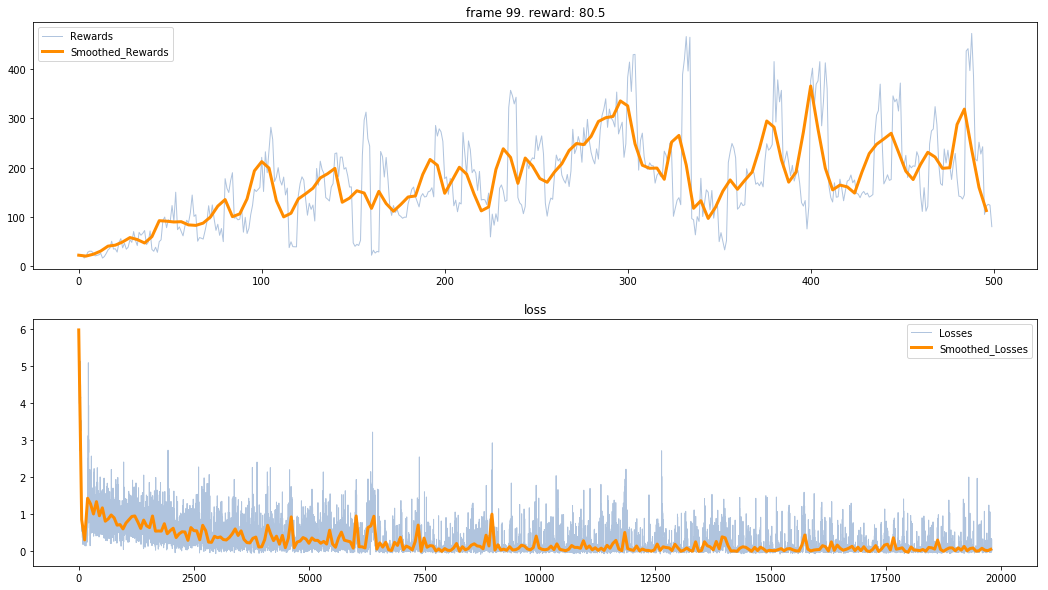

In [8]:
state = envs.reset()
test_rewards = []
losses = []
for i in range(20000):
    log_probs, values, rewards, masks, gt_returns, entropy = [], [], [], [], [], 0
    for _ in range(5):
        state = torch.FloatTensor(state).to(device)
        prob, value = model(state)
        
        action = prob.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        state = next_state
        
        log_probs.append(prob.log_prob(action))
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1-done).unsqueeze(1).to(device))
        entropy += prob.entropy().mean()
        
        if i % 200 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(i // 200, test_rewards, losses)
    
    # train
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    
    R = next_value
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R * masks[i]
        gt_returns.insert(0, R)
    
    log_probs, gt_returns, values = torch.cat(log_probs), torch.cat(gt_returns).detach(), torch.cat(values)
    
    advantage = gt_returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    loss = (actor_loss + 0.5 * critic_loss - 0.001 * entropy).to(device)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()